In [1]:
import sqlite3
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

Создаём курсор:

In [2]:
con = sqlite3.connect('imdb_small_indexed.db')
cur = con.cursor()

Создаём таблицу:

In [4]:
cur.execute("""
CREATE TABLE my_films_new (
    title_id INT, 
    title TEXT, 
    premiered INT,
    rating REAL,
    PRIMARY KEY (title_id)
)
""")

Находим подходящие фильмы (Мне было лень выбирать фильмы вручную, поэтому здесь фильмы, номера которых кончаются на 0000):

In [5]:
my_films_qu = """
SELECT title_id, title, premiered
FROM titles
WHERE title_id LIKE "%0000"
ORDER BY title_id DESC
"""

Дальше рандомно расставляем рейтинг:

In [6]:
cur.execute(my_films_qu)
data = cur.fetchall()
new_data = []
for x in data:
    r = random.randint(0, 10)
    y = list(x)
    y.append(r)
    x = tuple(y)
    new_data.append(x)

In [7]:
cur.executemany("INSERT INTO my_films_new VALUES (?, ?, ?, ?)", new_data)
cur.fetchall()
con.commit()

Делаем индекс:

In [10]:
my_index_qu = """
CREATE INDEX my_rating_ind_new ON my_films_new (rating)
"""
cur.execute(my_index_qu)
cur.fetchall()

[]

* LIMIT +
* WHERE без соединения таблиц +
* JOIN +
* GROUP BY + HAVING +
* GROUP_CONCAT
* математические агрегирующие функции (MAX, AVG и т.д.) +

Выбираем такие фильмы, что:
- рейтинг больше 4
- наиболее новые
- только четыре

In [12]:
one_qu = """
SELECT title, premiered
FROM my_films_new
WHERE rating > 2
ORDER BY premiered DESC
LIMIT 4"""
cur.execute(one_qu)
cur.fetchall()

[('Project Power', 2020),
 ('Junaci nasega doba', 2020),
 ('Zlota', 2019),
 ('Cry for the Bad Man', 2019)]

Выбираем фильмы, у которых не совпадает мой рейтинг и рейтинг из большой таблицы:

In [14]:
two_qu = """
SELECT my_films_new.title, my_films_new.rating
FROM my_films_new
    JOIN rating ON my_films_new.title_id = rating.title_id
WHERE my_films_new.rating != rating.rating
LIMIT 10"""
cur.execute(two_qu)
cur.fetchall()

[('Cocoanut Grove', 2.0),
 ('The Woman on the Beach', 4.0),
 ('Boots and Saddles', 10.0),
 ('Lehrer leben länger', 3.0),
 ("The Devil's Keep", 10.0),
 ('Enamored', 8.0),
 ('Ozzie', 8.0),
 ('Mat to sing suk si chi mat to sin chi', 3.0),
 ('No Blood No Tears', 1.0),
 ('Fastlane', 0.0)]

Считаем средний рейтинг для фильмов для каждого года, если в этом году вышло больше одного фильма:

In [15]:
three_qu = """
SELECT AVG(rating), premiered
FROM my_films_new
WHERE premiered != "None"
GROUP BY premiered HAVING COUNT(*) > 1"""
cur.execute(three_qu)
cur.fetchall()

[(3.0, 1919),
 (6.0, 1938),
 (6.5, 1966),
 (4.0, 1992),
 (6.5, 1994),
 (8.0, 1995),
 (5.5, 1999),
 (3.0, 2002),
 (4.2, 2006),
 (9.25, 2007),
 (7.0, 2010),
 (5.5, 2012),
 (4.5, 2013),
 (3.6666666666666665, 2014),
 (7.166666666666667, 2015),
 (4.571428571428571, 2016),
 (6.75, 2017),
 (6.4, 2018),
 (5.555555555555555, 2019),
 (3.4, 2020)]

In [16]:
my_table = pd.read_sql_query(three_qu, con = con)

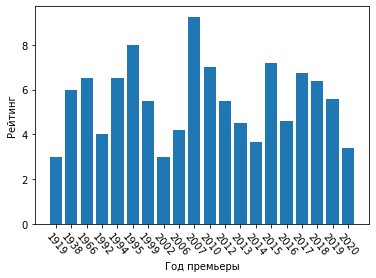

In [17]:
height = list(my_table["AVG(rating)"])
bars = tuple(my_table["premiered"])
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = -50)
plt.xlabel('Год премьеры')
plt.ylabel('Рейтинг')
plt.show()


Нужно добавить ещё две таблицы:
- в первой будет номер фильма, номер оценившего человека и оценка;
- во второй будет информация о людях.

![это таблица](https://raw.githubusercontent.com/YanaKoko/try/master/таблица.png)